In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model




In [ ]:
image_dir = "/content/kaggle_3m"
img_size = (128, 128)

images, masks = [], []

for folder_name in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    for file_name in sorted(os.listdir(folder_path)):
        if 'mask' not in file_name.lower():
            continue

        mask_path = os.path.join(folder_path, file_name)
        image_filename = file_name.replace('_mask', '')
        image_path = os.path.join(folder_path, image_filename)

        if not os.path.exists(image_path):
            continue

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = cv2.resize(img, img_size) / 255.0
        mask = cv2.resize(mask, img_size) / 255.0

        images.append(img[..., np.newaxis])
        masks.append(mask[..., np.newaxis])

X = np.array(images, dtype=np.float32)
y = np.array(masks, dtype=np.float32)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Total folders:", len(image_dir))
print("Total images loaded:", len(images))
print("Total masks loaded:", len(masks))
print("Shape of image dataset (X):", X.shape)
print("Shape of mask dataset (y):", y.shape)
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)


Total folders: 18
Total images loaded: 3929
Total masks loaded: 3929
Shape of image dataset (X): (3929, 128, 128, 1)
Shape of mask dataset (y): (3929, 128, 128, 1)
Train set shape: (3143, 128, 128, 1) (3143, 128, 128, 1)
Validation set shape: (786, 128, 128, 1) (786, 128, 128, 1)


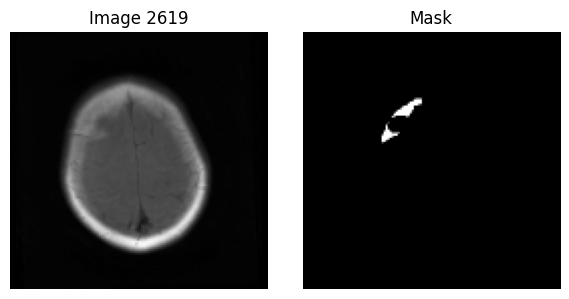

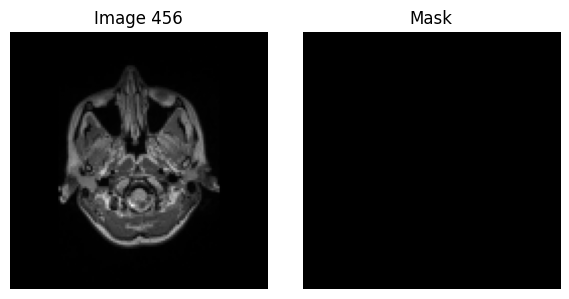

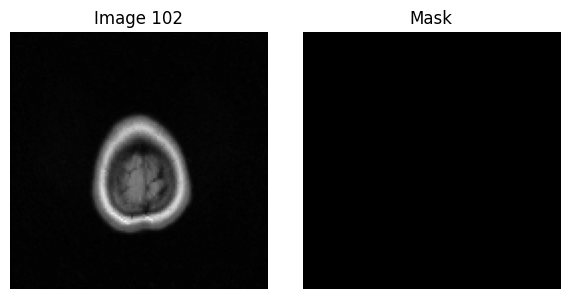

In [ ]:
import random

def show_image_and_mask(index):
    plt.figure(figsize=(6, 3))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(X[index].squeeze(), cmap='gray')
    plt.title(f"Image {index}")
    plt.axis('off')

    # Display corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(y[index].squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

random.seed(42)

# Show 3 random samples
random_indices = random.sample(range(len(X)), 3)
for idx in random_indices:
    show_image_and_mask(idx)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, 3, activation='relu', padding='same')(p3)

    # Decoder
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c3])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u1)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u2)

    u3 = Conv2DTranspose(16, 2, strides=2, padding='same')(c5)
    u3 = concatenate([u3, c1])
    c6 = Conv2D(16, 3, activation='relu', padding='same')(u3)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(c6)

    return Model(inputs, outputs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_unet_model.h5', save_best_only=True, verbose=1)
]


In [ ]:
model = unet_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9609 - loss: 0.1994
Epoch 1: val_loss improved from inf to 0.04049, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9610 - loss: 0.1989 - val_accuracy: 0.9888 - val_loss: 0.0405
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9887 - loss: 0.0385
Epoch 2: val_loss improved from 0.04049 to 0.03742, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9887 - loss: 0.0385 - val_accuracy: 0.9888 - val_loss: 0.0374
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9889 - loss: 0.0367
Epoch 3: val_loss improved from 0.03742 to 0.03661, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9889 - loss: 0.0367 - val_accuracy: 0.9888 - val_loss: 0.0366
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9899 - loss: 0.0337
Epoch 4: val_loss improved from 0.03661 to 0.03548, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.9899 - loss: 0.0337 - val_accuracy: 0.9888 - val_loss: 0.0355
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.0350
Epoch 5: val_loss improved from 0.03548 to 0.03440, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9888 - loss: 0.0350 - val_accuracy: 0.9888 - val_loss: 0.0344
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9887 - loss: 0.0341
Epoch 6: val_loss improved from 0.03440 to 0.03402, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9887 - loss: 0.0341 - val_accuracy: 0.9892 - val_loss: 0.0340
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9894 - loss: 0.0336
Epoch 7: val_loss improved from 0.03402 to 0.03314, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9894 - loss: 0.0336 - val_accuracy: 0.9894 - val_loss: 0.0331
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9901 - loss: 0.0314
Epoch 8: val_loss did not improve from 0.03314
197/197 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9901 - loss: 0.0314 - val_accuracy: 0.9894 - val_loss: 0.0344
Epoch 9/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9907 - loss: 0.0291
Epoch 9: val_loss improved from 0.03314 to 0.02855, saving model to best_unet_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9907 - loss: 0.0291 - val_accuracy: 0.9906 - val_loss: 0.0285
Epoch 10/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9907 - loss: 0.0278
Epoch 10: val_loss did not improve from 0.02855
197/197 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9907 - loss: 0.0278 - val_accuracy: 0.9905 - val_loss: 0.0291
Restoring model weights from the end of the best epoch: 9.


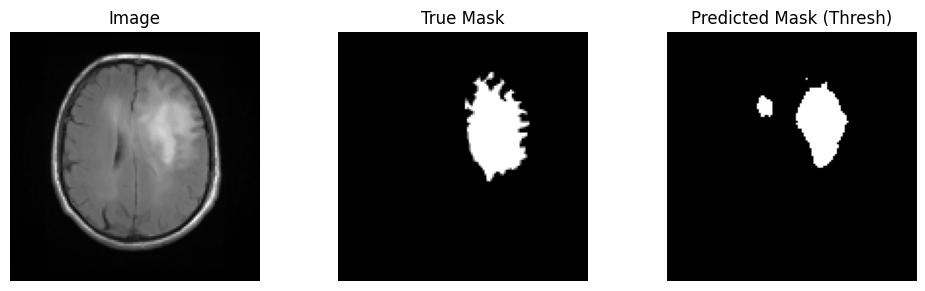

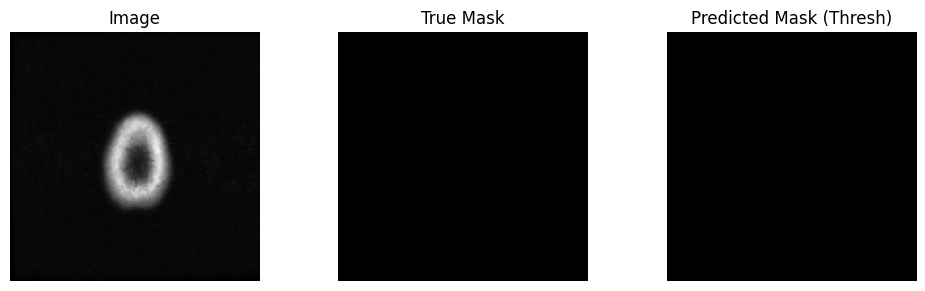

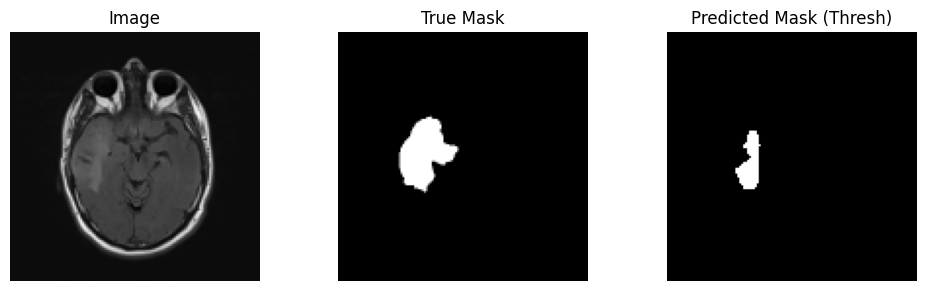

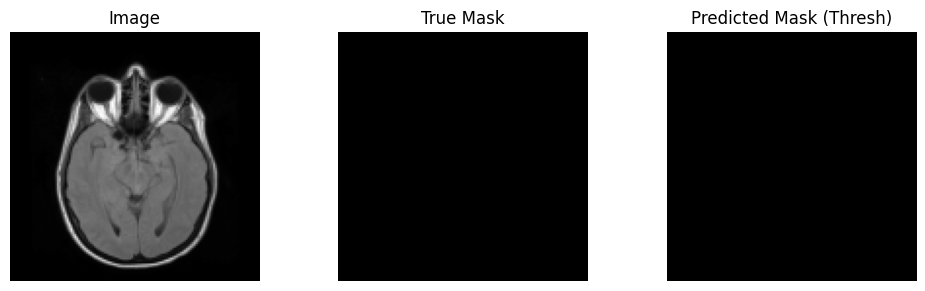

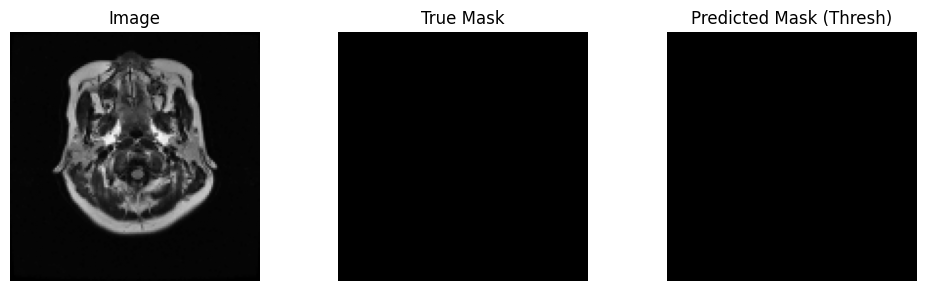

In [ ]:
def show_prediction(index, threshold=True, save=False):
    img = X_val[index]
    true_mask = y_val[index]


    pred_mask = model.predict(img[np.newaxis, ...], verbose=0)[0]

    display_mask = (pred_mask > 0.5).astype(np.float32) if threshold else pred_mask

    
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(display_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask" + (" (Thresh)" if threshold else ""))
    plt.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig(f"prediction_{index}.png", bbox_inches='tight')

    plt.show()

# Show first 5 predictions
for i in range(5):
    show_prediction(i)


In [ ]:
model.save("unet.keras")